# 2017-11-17: Nearest Neighbors

In this lab, we will apply nearest neighbors classification to the Endometrium vs. Uterus cancer data. For documentation, see:
* http://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification; and 
* http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

We will implement our own nearest neighbors classifier and compare the results with the in-built classifiers offered by scikit-learn. 

Let us start by setting up our environment, loading the data, and setting up our cross-validation.

In [42]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/thomas/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Load the data as in the previous labs. We will use `small_Endometrium_Uterus.csv` for this lab.

(183, 3000)


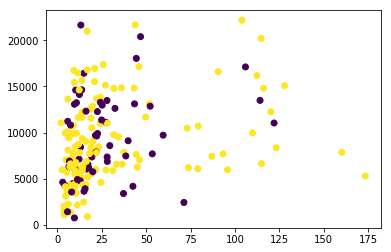

In [43]:
from sklearn import preprocessing

# load the endometrium vs. uterus tumor data
endometrium_data = pd.read_csv('data/small_Endometrium_Uterus.csv', sep=",")  # load data
endometrium_data.head(n=5)  # adjust n to view more data

# Create the design matrix and target vector
X_clf = endometrium_data.drop(['ID_REF', 'Tissue'], axis=1).values
y_clf = pd.get_dummies(endometrium_data['Tissue']).values[:,1]

print(X_clf.shape)
plt.scatter(X_clf[:,0], X_clf[:,1], c=y_clf)

Recall functions we had used to create cross validation folds in the previous labs. Redefine them here. 

*Note* : We shall call this *m*-fold cross validation, unlike *k*-fold, which we used in our previous labs, to distinguish it from *k*-nearest neighbors classification. This emphasizes that the two parameters are indeed different from each other.

In [44]:
from sklearn import model_selection

def stratifiedMFolds(y, num_folds):
    kf = model_selection.StratifiedKFold(n_splits=num_folds)
    folds_regr = [(tr, te) for (tr, te) in kf.split(np.zeros(y.size), y)]
    return folds_regr

Now create 10 cross validate folds on the data. 

In [45]:
cv_folds = stratifiedMFolds(y_clf, 10)

Import the previously written cross validation function.

In [46]:
# let's redefine the cross-validation procedure with standardization
from sklearn import preprocessing
def cross_validate(design_matrix, labels, regressor, cv_folds):
    """ Perform a cross-validation and returns the predictions. 
    Use a scaler to scale the features to mean 0, standard deviation 1.
    
    Parameters:
    -----------
    design_matrix: (n_samples, n_features) np.array
        Design matrix for the experiment.
    labels: (n_samples, ) np.array
        Vector of labels.
    classifier:  Regressor instance; must have the following methods:
        - fit(X, y) to train the regressor on the data X, y
        - predict_proba(X) to apply the trained regressor to the data X and return predicted values
    cv_folds: sklearn cross-validation object
        Cross-validation iterator.
        
    Return:
    -------
    pred: (n_samples, ) np.array
        Vectors of predictions (same order as labels).
    """
    
    n_classes = np.unique(labels).size
    pred = np.zeros((labels.shape[0], n_classes))
    for tr, te in cv_folds:
        scaler = preprocessing.StandardScaler()
        Xtr = scaler.fit_transform(design_matrix[tr,:])
        ytr =  labels[tr]
        Xte = scaler.transform(design_matrix[te,:])
        regressor.fit(Xtr, ytr)
        pred[te, :] = regressor.predict_proba(Xte)
    return pred

# 1. *k*-Nearest Neighbours Classifier

A k-neighbours classifier can be initialised as `knn_clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)`

Cross validate 20 *k*-NN classifiers on the loaded datset using `cross_validate`. 

In [47]:
from sklearn import neighbors
from sklearn import metrics

aurocs_clf = []
# Create a range of values of k. We will use this throughout the lab.
k_range    = range(1,40,2) 

for k in k_range:
    clf    = neighbors.KNeighborsClassifier(n_neighbors=k)
    y_pred = cross_validate(X_clf, y_clf, clf, cv_folds)
    
    fpr, tpr, thresholdss = metrics.roc_curve(y_clf, y_pred[:,1])
    aurocs_clf.append(metrics.auc(fpr,tpr))

Now plot the AUC as a function of the number of nearest neighbours chosen.

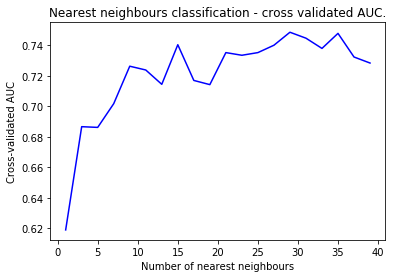

In [48]:
plt.plot(k_range, aurocs_clf, color='blue')
plt.xlabel('Number of nearest neighbours')
plt.ylabel('Cross-validated AUC')
plt.title('Nearest neighbours classification - cross validated AUC.')

**Question.** Find the best value for the parameter `n_neighbors` by finding the one that gives the maximum value of AUC.

In [49]:
best_k = np.argmax(aurocs_clf)
print(k_range[best_k])

29


Let us now use `sklearn.model_selection.GridSearchCV` do to the same. The parameter to be cross-validated is the number of nearest neighbours to choose. Use an appropriate list to feed to `GridSearchCV` to find the best value for the nearest neighbours parameter.

In [50]:
from sklearn import model_selection
from sklearn import metrics

classifier = neighbors.KNeighborsClassifier()
# TODO
param_grid = {'n_neighbors': k_range}
clf_knn_opt = model_selection.GridSearchCV(classifier,  param_grid=param_grid, cv=cv_folds)
clf_knn_opt.fit(X_clf, y_clf)

GridSearchCV(cv=[(array([ 19,  20, ..., 181, 182]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 25])), (array([  0,   1, ..., 181, 182]), array([19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 44])), (array([  0,   1, ..., 181, 182]), a...[165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182]))],
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 40, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
# Find the best parameter
print(clf_knn_opt.best_params_)

{'n_neighbors': 25}


Try choosing different scoring metrics for GridSearchCV, and see how the result changes. You can find scoring metrics [here](http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

Now compare the performance of the *k*-nearest neighbours classifier with logistic regularisation (both, non-regularised, and regularised).

In [52]:
from sklearn import linear_model

cvalues_list = np.logspace(-5, 1, 20)
clf_logreg = linear_model.LogisticRegression(penalty='l2')
logreg_params = {'C': cvalues_list}
                
clf_logreg_opt = model_selection.GridSearchCV(clf_logreg, param_grid=logreg_params, cv=cv_folds)
clf_logreg_opt.fit(X_clf, y_clf)
ypred_clf_logreg_opt = cross_validate(X_clf, y_clf, clf_logreg_opt.best_estimator_, cv_folds)
fpr_clf_logreg_opt, tpr_clf_logreg_opt, thresh = metrics.roc_curve(y_clf, ypred_clf_logreg_opt[:,1])

In [53]:
clf_logreg_l2 = linear_model.LogisticRegression(C=1e12)
clf_logreg_l2.fit(X_clf, y_clf)
ypred_clf_logreg_l2 = cross_validate(X_clf, y_clf, clf_logreg_l2, cv_folds)
fpr_clf_logreg_l2, tpr_clf_logreg_l2, thresh = metrics.roc_curve(y_clf, ypred_clf_logreg_l2[:,1])

In [55]:
ypred_clf_knn_opt = cross_validate(X_clf, y_clf, clf_knn_opt.best_estimator_, cv_folds)
fpr_clf_knn_opt, tpr_clf_knn_opt, thresh = metrics.roc_curve(y_clf, ypred_clf_knn_opt[:,1])

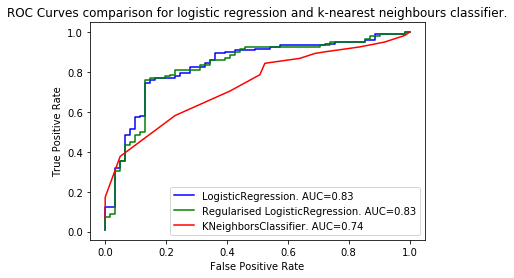

In [56]:
logreg_l2_h,  = plt.plot(fpr_clf_logreg_opt, tpr_clf_logreg_opt, 'b-')
logreg_h,     = plt.plot(fpr_clf_logreg, tpr_clf_logreg, 'g-')
knn_h,        = plt.plot(fpr_clf_knn_opt, tpr_clf_knn_opt, 'r-')
logreg_l2_auc    = metrics.auc(fpr_clf_logreg_opt, tpr_clf_logreg_opt)
logreg_auc = metrics.auc(fpr_clf_logreg, tpr_clf_logreg)
knn_auc       = metrics.auc(fpr_clf_knn_opt, tpr_clf_knn_opt)


logreg_legend    = 'LogisticRegression. AUC=%.2f' %(logreg_auc)
logreg_l2_legend = 'Regularised LogisticRegression. AUC=%.2f' %(logreg_l2_auc)
knn_legend       = 'KNeighborsClassifier. AUC=%.2f' %(knn_auc)
plt.legend([logreg_h, logreg_l2_h, knn_h], [logreg_legend, logreg_l2_legend, knn_legend])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves comparison for logistic regression and k-nearest neighbours classifier.')
plt.show()

**Setting the distance measure**. You will notice that *k*-nearest neighbours classifiers measure distances between points to determine similarity. By default, we use the Euclidean distance metric. Often, using other distance metrics can prove to be helpful. Try to change the distance metric used here by passing it as an argument to the declaration of the classifier. 

In [60]:
classifiers = {}            
y_preds     = {}            
# Fix a set of distance metrics to use
d_metrics = ['euclidean', 'cityblock', 'correlation' , 'cosine']
aurocs    = {}      

for m in d_metrics:
    aurocs[m] = []          
    for k in k_range: 
        classifiers[m] = neighbors.KNeighborsClassifier(n_neighbors=k, metric=m) #Initialise a kNN classifier with n_neighbors=k and metric=m
        y_preds[m]     = cross_validate(X_clf, y_clf, classifiers[m], cv_folds) #Cross validate on the data. Use cross_validate
    
        fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_preds[m][:,1])
        auc                  = metrics.auc(fpr, tpr)
        aurocs[m].append(auc)     
        
        print('Metric = %-12s | k = %3d | AUC = %.3f.' %(m, k, aurocs[m][-1]))

Metric = euclidean    | k =   1 | AUC = 0.619.
Metric = euclidean    | k =   3 | AUC = 0.687.
Metric = euclidean    | k =   5 | AUC = 0.686.
Metric = euclidean    | k =   7 | AUC = 0.702.
Metric = euclidean    | k =   9 | AUC = 0.726.
Metric = euclidean    | k =  11 | AUC = 0.724.
Metric = euclidean    | k =  13 | AUC = 0.714.
Metric = euclidean    | k =  15 | AUC = 0.740.
Metric = euclidean    | k =  17 | AUC = 0.717.
Metric = euclidean    | k =  19 | AUC = 0.714.
Metric = euclidean    | k =  21 | AUC = 0.735.
Metric = euclidean    | k =  23 | AUC = 0.734.
Metric = euclidean    | k =  25 | AUC = 0.735.
Metric = euclidean    | k =  27 | AUC = 0.740.
Metric = euclidean    | k =  29 | AUC = 0.749.
Metric = euclidean    | k =  31 | AUC = 0.745.
Metric = euclidean    | k =  33 | AUC = 0.738.
Metric = euclidean    | k =  35 | AUC = 0.748.
Metric = euclidean    | k =  37 | AUC = 0.732.
Metric = euclidean    | k =  39 | AUC = 0.728.
Metric = cityblock    | k =   1 | AUC = 0.598.
Metric = city

Now plot ROC curves for all the metrics together.

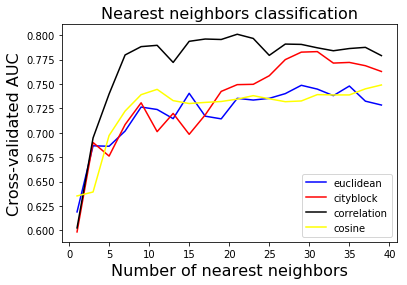

In [61]:
f = plt.figure()
handles = [[] for i in range(len(d_metrics))]
colours = ['blue', 'red', 'black', 'yellow'] 
for i in range(len(d_metrics)):              
    handles[i], = plt.plot(k_range, aurocs[d_metrics[i]], color=colours[i])  # SOLUTION

plt.xlabel('Number of nearest neighbors', fontsize=16)
plt.ylabel('Cross-validated AUC', fontsize=16)
plt.title('Nearest neighbors classification', fontsize=16)
plt.legend(handles, d_metrics)

# 2. Kaggle Challenge.

Cross-validate a *k*-NN on the challenge's data and submit to the leaderboard. What scoring criterion are you using? How does the leaderboard performance compare to your cross-validated performance?

# 3. Bonus: Implementating *k*-Nearest Neighbours

In this section, you can write your own nearest neighbours classifier.

Create a class to define a *k*-nearest neighbor classifier. The class must define certain functions (according to convention) - `fit`, `predict`, and `predict_proba`. `fit` takes as argument some data, and fits the classifier to it. `predict` and `predict_proba` also take some data, but predict class labels on this data based on the fitted classifier. These definitions are described below. `predict_proba` assigns a probability vector for each test point, representing its confidence in that test point belonging to each of the classes. 

In [129]:
from sklearn.metrics import pairwise_distances

class kNNClassifier:
    # To start, determine what members this class must have. 
    # Recall that Python does not have public and private class members. 
    
    # Define the __init__ function. 
    def __init__(self, k=3):
        self.k    = k
        self.data = None
    
    # Define the fit function. You must also use an appropriate function prototype. 
    def fit(self, X, y):
        self.data      = X
        
        # Fix class labels so that they are in [0, num_labels].
        self.target    = y
        self.classes   = np.unique(y)
        self.n_classes = self.classes.size
        d              = {}
        for i in range(self.n_classes):
            d[self.classes[i]] = i
        # Now use self._target as a mapping.
        self._target   = np.array([d[i] for i in self.target], dtype=np.int)  
    
    # Define the predict_proba function. You must use an appropriate function prototype. 
    def predict_proba(self, X):        
        n_test, n_vars  = X.shape
        n_train, n_vars = self.data.shape
                
        dists = pairwise_distances(X, self.data) #Find pairwise distances between each point in X and each point in self.data
        top_k = np.argsort(dists, axis=1)# TODO: For each point in X, sort these distance and retrieve self.k closest points from self.data
        # TODO: For each point in X, compute probabilities of it belonging to each class. The probability
        #       of a point belonging to a class is simply the number of neighbours of that class in the top-k 
        #       divided by k.
        probs = np.array([[(self._target[top_k[i,:self.k]]==j).sum() for j in range(self.n_classes)] for i in range(len(X))])
        return probs
    
    # Define the predict function. You must also use an appropriate function prototype. 
    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]
        pass


Now that we have the class defined, we can use it. Define an instance of the `kNNClassifier` below with 3 neighbors, and fit the classifier to our design matrix `X`. But first we create cross validation folds. 10 sounds like a good-enough number.

In [130]:
l = np.array([[1,4,2], [7,5,4]])
np.argsort(l, axis=1)

array([[0, 2, 1],
       [2, 1, 0]])

In [131]:
cv_folds = stratifiedMFolds(y_clf, 10)   # SOLUTION.

Use this to obtain a prediction on the entire data. Use `k = 3`, as example.

In [132]:
knn_3       = kNNClassifier()
y_pred_cv   = cross_validate(X_clf, y_clf, knn_3, cv_folds)

Calculate the area under the ROC curve for these two folds. 

In [133]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_pred_cv[:,1])
cv_auc               = metrics.auc(fpr, tpr)

print('AUC, 10-fold cross validation: %f' %(cv_auc))

AUC, 10-fold cross validation: 0.686643


Try changing the value of `k` here. Try odd values from 1 to 29, inclusive. Compare their performances by plotting them.

**Question**: Why aren't we using even values here?

**Answer**: 

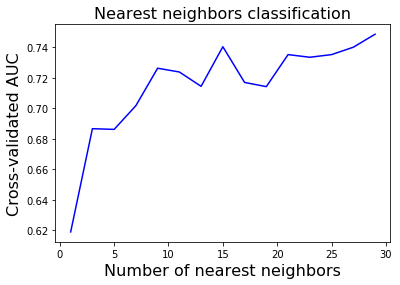

In [134]:
aurocs      = []
classifiers = {}
y_preds     = {}

# Calculate area under the ROC curves for different values of k.
for k in range(1, 30, 2):
    classifiers[k] = kNNClassifier(k)        
    y_preds[k]     = cross_validate(X_clf, y_clf, classifiers[k], cv_folds)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_preds[k][:,1])
    aurocs.append(metrics.auc(fpr, tpr))   
    
# Plot these values. 
f = plt.figure()
plt.plot(range(1, 30, 2), aurocs, color='blue')
plt.xlabel('Number of nearest neighbors', fontsize=16)
plt.ylabel('Cross-validated AUC', fontsize=16)
plt.title('Nearest neighbors classification', fontsize=16)

Now compare the graph you get here, with the one you obtained using the `sklearn` implementation.

Notice that our implementation of the *k*-nearest neighbors classifier uses the Euclidean distance measure (`pairwise_distances` uses this metric by default). However, for some types of data, some other distance measures are more useful. 
Read the documentation of `sklearn.metrics.pairwise_distances` [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html), and include another parameter in the definition of the class. This should subsequently be reflected in how the predict function of the class works as well. 

Define a new class `kNNClassifierMetric` that accepts, as argument, a distance measure to be used. 

In [135]:
class kNNClassifierMetric:
    # To start, determine what members this class must have. 
    # Recall that Python does not have public and private class members. 
    
    # Define the __init__ function. You must also use an appropriate function prototype. 
    def __init__(self, k=3, metric='euclidean'):
        self.k      = k
        self.data   = None
        self.metric = metric
    
    # Define the fit function. You must also use an appropriate function prototype. 
    def fit(self, X, y):
        self.data      = X
        
        # Fix class labels so that they are in [0, num_labels].
        self.target    = y
        self.classes   = np.unique(y)
        self.n_classes = self.classes.size
        d              = {}
        for i in range(self.n_classes):
            d[self.classes[i]] = i
        # Now use self._target as a mapping.
        self._target   = np.array([d[i] for i in self.target], dtype=np.int) 
 
    
    # Define the predict_proba function. You must use an appropriate function prototype. 
    def predict_proba(self, X):        
        n_test, n_vars  = X.shape
        n_train, n_vars = self.data.shape
        
        dists = pairwise_distances(X, self.data, metric=self.metric) #Find pairwise distances between each point in X and each point in self.data
        top_k = np.argsort(dists, axis=1)# TODO: For each point in X, sort these distance and retrieve self.k closest points from self.data
        # TODO: For each point in X, compute probabilities of it belonging to each class. The probability
        #       of a point belonging to a class is simply the number of neighbours of that class in the top-k 
        #       divided by k.
        probs = np.array([[(self._target[top_k[i,:self.k]]==j).sum() for j in range(self.n_classes)] for i in range(len(X))])
        return probs
        
    # Define the predict function. You must also use an appropriate function prototype. 
    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]
        pass


As previously, we again predict the class labels for our dataset - 

In [138]:
from sklearn import metrics

classifiers = {}
y_preds     = {}
# Fix a set of distance metrics to use
d_metrics = ['euclidean', 'cityblock', 'correlation' , 'cosine']
for m in d_metrics:
    classifiers[m] = kNNClassifierMetric(k=3, metric=m)    
    y_preds[m]     = cross_validate(X_clf, y_clf, classifiers[m], cv_folds)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_preds[m][:,1])
    auc                  = metrics.auc(fpr, tpr)
    
    print('Metric %s. AUC, 10-fold cross validation: %f' %(m, auc))

Metric euclidean. AUC, 10-fold cross validation: 0.686643
Metric cityblock. AUC, 10-fold cross validation: 0.690003
Metric correlation. AUC, 10-fold cross validation: 0.694706
Metric cosine. AUC, 10-fold cross validation: 0.639277


Do the same thing, but this time, try changing the parameter `k` as well. 

In [140]:
classifiers = {}    
y_preds     = {}    
# Fix a set of distance metrics to use
d_metrics = ['euclidean', 'cityblock', 'correlation' , 'cosine']
aurocs    = {}      

for m in d_metrics:
    aurocs[m] = []          
    for k in k_range: 
        classifiers[m] = kNNClassifierMetric(k=k, metric=m)    
        y_preds[m]     = cross_validate(X_clf, y_clf, classifiers[m], cv_folds)
        
        fpr, tpr, thresholds = metrics.roc_curve(y_clf, y_preds[m][:,1])
        auc                  = metrics.auc(fpr, tpr)
        aurocs[m].append(auc)     # SOLUTION.
        
        print('Metric = %-12s | k = %3d | AUC = %.3f.' %(m, k, aurocs[m][-1]))

Metric = euclidean    | k =   1 | AUC = 0.619.
Metric = euclidean    | k =   3 | AUC = 0.687.
Metric = euclidean    | k =   5 | AUC = 0.686.
Metric = euclidean    | k =   7 | AUC = 0.702.
Metric = euclidean    | k =   9 | AUC = 0.726.
Metric = euclidean    | k =  11 | AUC = 0.724.
Metric = euclidean    | k =  13 | AUC = 0.714.
Metric = euclidean    | k =  15 | AUC = 0.740.
Metric = euclidean    | k =  17 | AUC = 0.717.
Metric = euclidean    | k =  19 | AUC = 0.714.
Metric = euclidean    | k =  21 | AUC = 0.735.
Metric = euclidean    | k =  23 | AUC = 0.734.
Metric = euclidean    | k =  25 | AUC = 0.735.
Metric = euclidean    | k =  27 | AUC = 0.740.
Metric = euclidean    | k =  29 | AUC = 0.749.
Metric = euclidean    | k =  31 | AUC = 0.745.
Metric = euclidean    | k =  33 | AUC = 0.738.
Metric = euclidean    | k =  35 | AUC = 0.748.
Metric = euclidean    | k =  37 | AUC = 0.732.
Metric = euclidean    | k =  39 | AUC = 0.728.
Metric = cityblock    | k =   1 | AUC = 0.598.
Metric = city

Now plot all the curves on the same graph. Also try adding a legend to the plot.

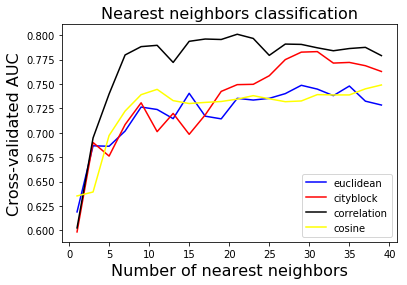

In [141]:
f = plt.figure()
handles = [[] for i in range(len(d_metrics))]  
colours = ['blue', 'red', 'black', 'yellow']   
for i in range(len(d_metrics)):                
    handles[i], = plt.plot(k_range, aurocs[d_metrics[i]], color=colours[i])  

plt.xlabel('Number of nearest neighbors', fontsize=16)
plt.ylabel('Cross-validated AUC', fontsize=16)
plt.title('Nearest neighbors classification', fontsize=16)
plt.legend(handles, d_metrics)

Note the effect of choosing different distance metrics.